In [36]:
### Name: Nischal Joshi
### Course: Advanced Data Mining and Big Data
### Date: 07/19/2025
#  
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from mlxtend.frequent_patterns import apriori, fpgrowth, association_rules
from mlxtend.preprocessing import TransactionEncoder
import numpy as np
import time

In [37]:
# Loading the data set.

users_df = pd.read_csv('Users.csv', delimiter=';', encoding='latin-1')
ratings_df = pd.read_csv('Ratings.csv', delimiter=';', encoding='latin-1')
# The 'on_bad_lines' parameter is crucial for this specific dataset due to parsing errors
books_df = pd.read_csv('Books.csv', delimiter=';', encoding='latin-1', on_bad_lines='skip')

/var/folders/py/r1rt0zjx5rddylvd4fhnyfww0000gn/T/ipykernel_53027/1680730791.py:3: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  users_df = pd.read_csv('Users.csv', delimiter=';', encoding='latin-1')


In [38]:
# Initial exploration of the dataset to get idea of the attributes
print("\nUsers Info:")
users_df.info()
print(users_df.head())

print("\nRatings Info:")
ratings_df.info()
print(ratings_df.head())

print("\nBooks Info:")
books_df.info()
print(books_df.head())


Users Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278859 entries, 0 to 278858
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   User-ID  278859 non-null  object
 1   Age      168627 non-null  object
dtypes: object(2)
memory usage: 4.3+ MB
  User-ID  Age
0       1  NaN
1       2   18
2       3  NaN
3       4   17
4       5  NaN

Ratings Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149780 entries, 0 to 1149779
Data columns (total 3 columns):
 #   Column   Non-Null Count    Dtype 
---  ------   --------------    ----- 
 0   User-ID  1149780 non-null  int64 
 1   ISBN     1149780 non-null  object
 2   Rating   1149780 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 26.3+ MB
   User-ID        ISBN  Rating
0   276725  034545104X       0
1   276726  0155061224       5
2   276727  0446520802       0
3   276729  052165615X       3
4   276729  0521795028       6

Books Info:
<class 'pandas.core.fra

In [39]:
# Data cleaning 
# Removing the duplicate data.
books_df = books_df.drop_duplicates(subset='ISBN')
users_df = users_df.drop_duplicates()
ratings_df = ratings_df.drop_duplicates()

# Dropping implicit rating
ratings_df = ratings_df[ratings_df['Rating'] > 0]

In [40]:
# Merging the ratings with books on ISBN
ratings_books = pd.merge(ratings_df, books_df, on='ISBN', how='inner')
# Merging the result with users on User-ID
merged_df = pd.merge(ratings_books, users_df, on='User-ID', how='inner')
print(merged_df.head())
merged_df['Age'] = pd.to_numeric(merged_df['Age'], errors='coerce')
# Dropping the NaN ages
merged_df = merged_df.dropna(subset=['Age'])
# Keeping only the  reasonable age values (e.g., 5–100)
merged_df = merged_df[(merged_df['Age'] >= 5) & (merged_df['Age'] <= 100)]

  User-ID        ISBN  Rating                                         Title  \
0       8  0002005018       5                                  Clara Callan   
1       8  074322678X       5       Where You'll Find Me: And Other Stories   
2       8  0887841740       5                            The Middle Stories   
3       8  1552041778       5                                      Jane Doe   
4       8  1567407781       6  The Witchfinder (Amos Walker Mystery Series)   

                 Author  Year                 Publisher  Age  
0  Richard Bruce Wright  2001     HarperFlamingo Canada  NaN  
1           Ann Beattie  2002                  Scribner  NaN  
2           Sheila Heti  2004     House of Anansi Press  NaN  
3          R. J. Kaiser  1999                Mira Books  NaN  
4     Loren D. Estleman  1998  Brilliance Audio - Trade  NaN  


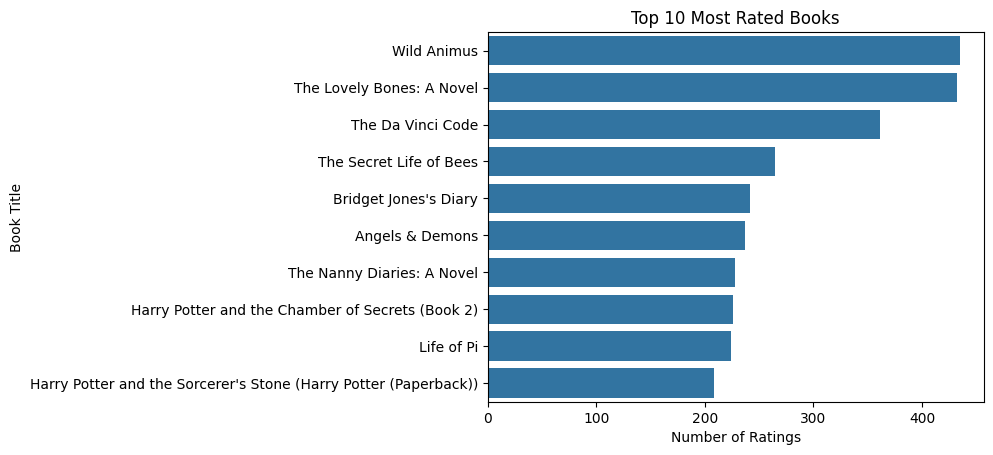

In [41]:
# Most frequent books
top_books = merged_df['Title'].value_counts().head(10)
sns.barplot(x=top_books.values, y=top_books.index)
plt.title('Top 10 Most Rated Books')
plt.xlabel('Number of Ratings')
plt.ylabel('Book Title')
plt.show()

In [42]:
# Keeping the active users
active_users = merged_df['User-ID'].value_counts()
merged_df = merged_df[merged_df['User-ID'].isin(active_users[active_users > 5].index)]
# Keeping the popular books
popular_books = merged_df['Title'].value_counts()
merged_df = merged_df[merged_df['Title'].isin(popular_books[popular_books > 20].index)]
#Convert to transaction format (User → list of books rated)
transactions = merged_df.groupby('User-ID')['Title'].apply(list).values.tolist()

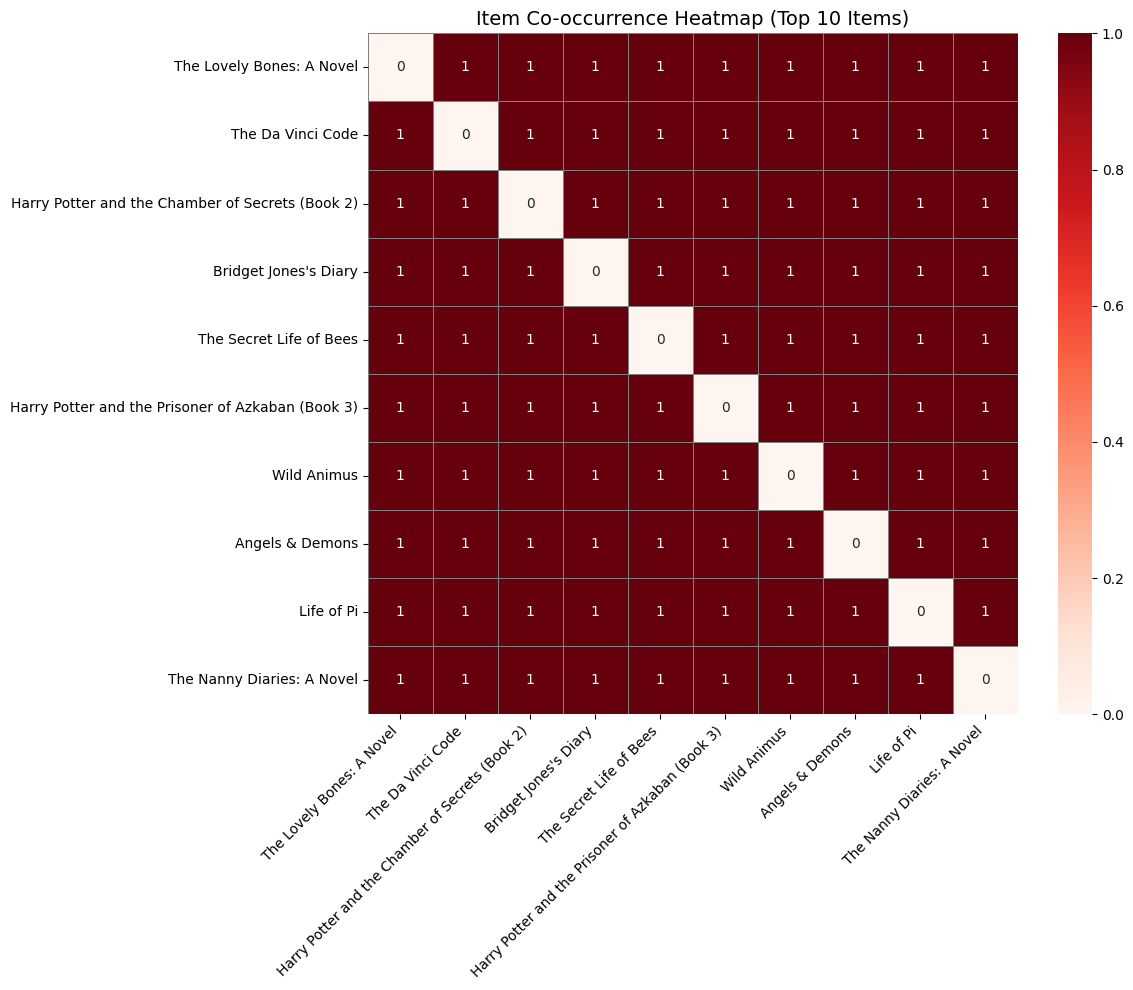

In [43]:
# Encode transactions using TransactionEncoder
te = TransactionEncoder()
df_encoded = pd.DataFrame(te.fit(transactions).transform(transactions), columns=te.columns_)
top_items = df_encoded.sum().sort_values(ascending=False).head(10).index

co_occurrence = df_encoded[top_items].T.dot(df_encoded[top_items])
np.fill_diagonal(co_occurrence.values, 0)  # remove self-co-occurrence

#Plotting the  heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(co_occurrence, cmap="Reds", annot=True, fmt='d', linewidths=0.5, linecolor='gray')
plt.title(f"Item Co-occurrence Heatmap (Top 10 Items)", fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [44]:
frequent_itemsets_apriori = apriori(df_encoded, min_support=0.01, use_colnames=True)
frequent_itemsets_apriori['length'] = frequent_itemsets_apriori['itemsets'].apply(lambda x: len(x))
# Taking Top 10 itemsets
frequent_itemsets_apriori.sort_values(by='support', ascending=False).head(10)

,support,itemsets,length
110,0.049230,(The Lovely Bones: A Novel),1
90,0.040730,(The Da Vinci Code),1
37,0.033823,(Harry Potter and the Chamber of Secrets (Book...,1
16,0.031521,(Bridget Jones's Diary),1
125,0.030459,(The Secret Life of Bees),1
40,0.029042,(Harry Potter and the Prisoner of Azkaban (Boo...,1
146,0.028511,(Wild Animus),1
12,0.027625,(Angels & Demons),1
52,0.027271,(Life of Pi),1
111,0.026917,(The Nanny Diaries: A Novel),1


/var/folders/py/r1rt0zjx5rddylvd4fhnyfww0000gn/T/ipykernel_53027/1528846485.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


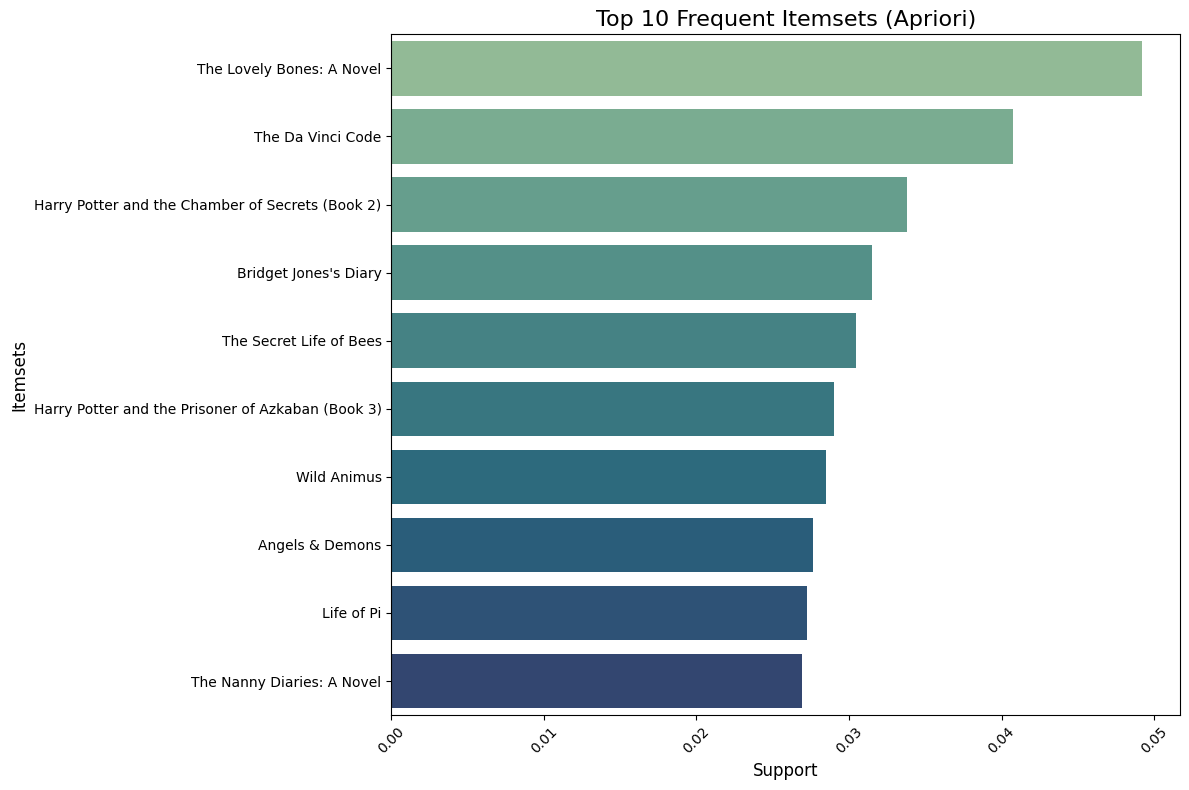

In [45]:
# Convert itemsets to readable strings
frequent_itemsets_apriori['itemset_str'] = frequent_itemsets_apriori['itemsets'].apply(lambda x: ', '.join(list(x)))
# Get top 10 frequent itemsets
top10_apriori = frequent_itemsets_apriori.sort_values('support', ascending=False).head(10)
# Set figure size
plt.figure(figsize=(12, 8))
# Barplot with better spacing
sns.barplot(
    data=top10_apriori,
    x='support',
    y='itemset_str',
    palette='crest'
)
# Labels and title
plt.title('Top 10 Frequent Itemsets (Apriori)', fontsize=16)
plt.xlabel('Support', fontsize=12)
plt.ylabel('Itemsets', fontsize=12)
# Improve layout and rotation
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

/var/folders/py/r1rt0zjx5rddylvd4fhnyfww0000gn/T/ipykernel_53027/1800498400.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top10_fpgrowth, x='support', y='itemset_str', palette='mako')


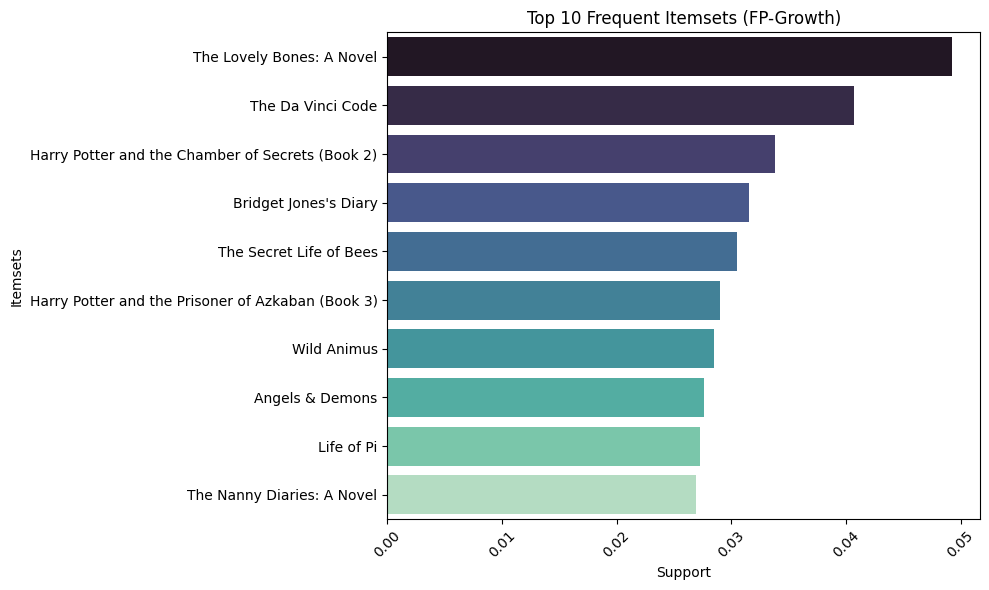

In [46]:
# Run FP-Growth algorithm
frequent_itemsets_fpgrowth = fpgrowth(df_encoded, min_support=0.01, use_colnames=True)

# Convert sets to strings for visualization
frequent_itemsets_fpgrowth['itemset_str'] = frequent_itemsets_fpgrowth['itemsets'].apply(lambda x: ', '.join(x))

# Get top 10 itemsets
top10_fpgrowth = frequent_itemsets_fpgrowth.sort_values(by='support', ascending=False).head(10)

# Plot top 10 itemsets
plt.figure(figsize=(10, 6))
sns.barplot(data=top10_fpgrowth, x='support', y='itemset_str', palette='mako')
plt.title("Top 10 Frequent Itemsets (FP-Growth)")
plt.xlabel("Support")
plt.ylabel("Itemsets")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


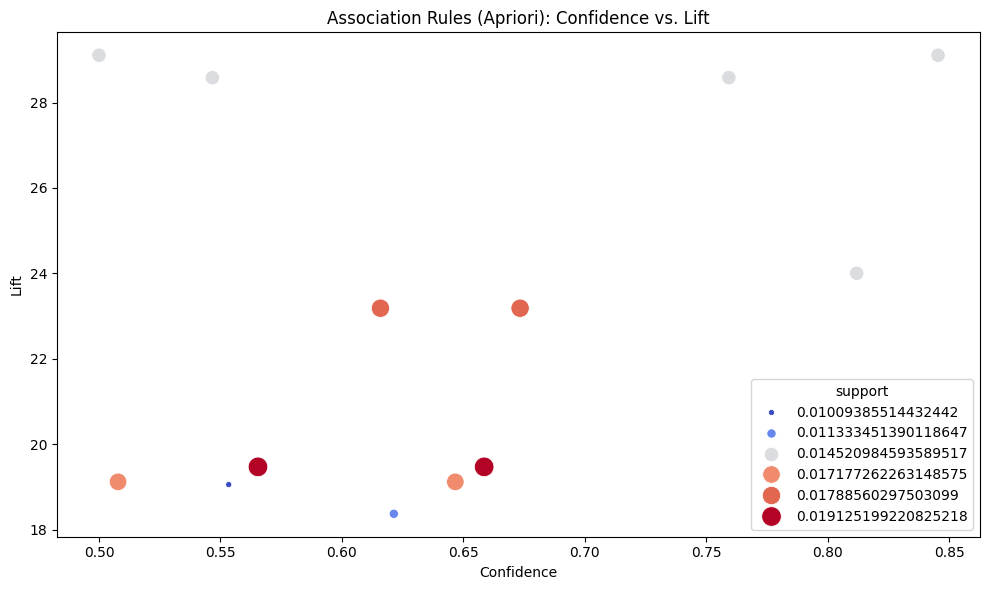

In [47]:
# Generate rules from Apriori results
rules_apriori = association_rules(frequent_itemsets_apriori, metric="confidence", min_threshold=0.5)

# Add string versions for visualization
rules_apriori['rule'] = rules_apriori['antecedents'].apply(lambda x: ', '.join(x)) + ' => ' + rules_apriori['consequents'].apply(lambda x: ', '.join(x))

# Scatter plot: Confidence vs. Lift
plt.figure(figsize=(10, 6))
sns.scatterplot(data=rules_apriori, x='confidence', y='lift', hue='support', size='support', sizes=(20, 200), palette='coolwarm')
plt.title("Association Rules (Apriori): Confidence vs. Lift")
plt.xlabel("Confidence")
plt.ylabel("Lift")
plt.tight_layout()
plt.show()



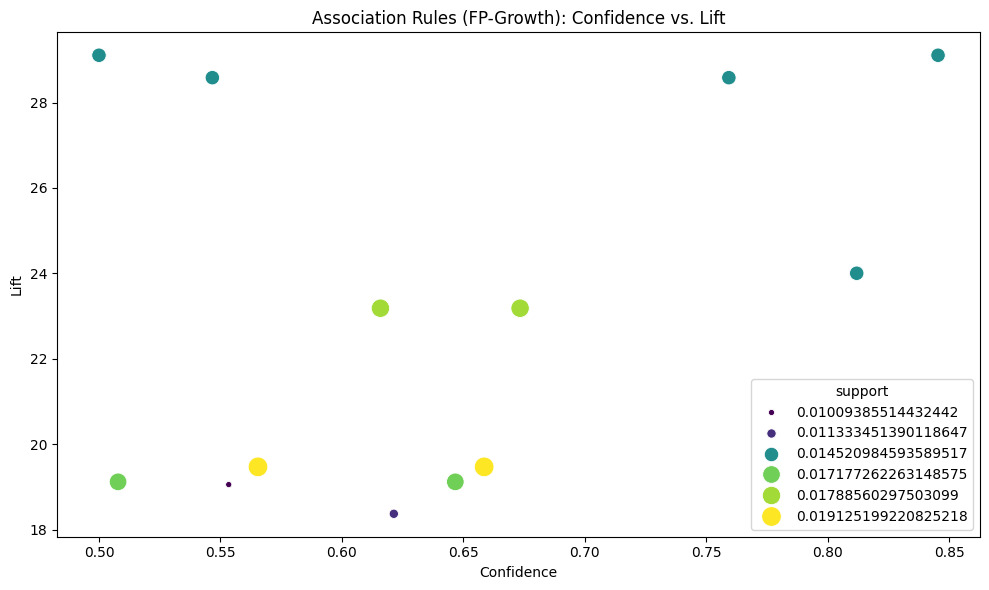

In [48]:
# Association rules for FP-Growth
rules_fpgrowth = association_rules(frequent_itemsets_fpgrowth, metric="confidence", min_threshold=0.5)

# Format rule strings for visualization
rules_fpgrowth['rule'] = rules_fpgrowth['antecedents'].apply(lambda x: ', '.join(x)) + ' => ' + rules_fpgrowth['consequents'].apply(lambda x: ', '.join(x))

# Scatter plot: Confidence vs. Lift (FP-Growth)
plt.figure(figsize=(10, 6))
sns.scatterplot(data=rules_fpgrowth, x='confidence', y='lift', hue='support', size='support', sizes=(20, 200), palette='viridis')
plt.title("Association Rules (FP-Growth): Confidence vs. Lift")
plt.xlabel("Confidence")
plt.ylabel("Lift")
plt.tight_layout()
plt.show()

In [49]:
# Timing Apriori
start = time.time()
frequent_itemsets_apriori = apriori(df_encoded, min_support=0.01, use_colnames=True)
apriori_time = time.time() - start
print(f"Apriori execution time: {apriori_time:.2f} seconds")

# Timing FP-Growth
start = time.time()
frequent_itemsets_fpgrowth = fpgrowth(df_encoded, min_support=0.01, use_colnames=True)
fpgrowth_time = time.time() - start
print(f"FP-Growth execution time: {fpgrowth_time:.2f} seconds")


Apriori execution time: 0.26 seconds
FP-Growth execution time: 0.18 seconds


In [50]:
print("Number of frequent itemsets (Apriori):", len(frequent_itemsets_apriori))
print("Number of frequent itemsets (FP-Growth):", len(frequent_itemsets_fpgrowth))

Number of frequent itemsets (Apriori): 157
Number of frequent itemsets (FP-Growth): 157


In [51]:
print("Number of association rules (Apriori):", len(rules_apriori))
print("Number of association rules (FP-Growth):", len(rules_fpgrowth))

Number of association rules (Apriori): 13
Number of association rules (FP-Growth): 13


In [55]:
print("=== TOP ASSOCIATION RULES INTERPRETATION ===\n")
top_rules = rules_fpgrowth.nlargest(5, 'lift')
    
for idx, (_, rule) in enumerate(top_rules.iterrows(), 1):
    antecedent = ', '.join(list(rule['antecedents']))
    consequent = ', '.join(list(rule['consequents']))
        
    print(f"Rule {idx}:")
    print(f"  If someone reads: '{antecedent}'")
    print(f"  They are {rule['confidence']:.2%} likely to also read: '{consequent}'")
    print(f"  This association is {rule['lift']:.2f}x stronger than random chance")
    print(f"  Support: {rule['support']:.3f} ({rule['support']*len(transactions):.0f} users)")
    print(f"  Business Impact: {'Very Strong' if rule['lift'] > 10 else 'Strong' if rule['lift'] > 5 else 'Moderate'}")
    print("-" * 80)

=== TOP ASSOCIATION RULES INTERPRETATION ===

Rule 1:
  If someone reads: 'Harry Potter and the Prisoner of Azkaban (Book 3)'
  They are 50.00% likely to also read: 'Harry Potter and the Chamber of Secrets (Book 2), Harry Potter and the Goblet of Fire (Book 4)'
  This association is 29.11x stronger than random chance
  Support: 0.015 (82 users)
  Business Impact: Very Strong
--------------------------------------------------------------------------------
Rule 2:
  If someone reads: 'Harry Potter and the Chamber of Secrets (Book 2), Harry Potter and the Goblet of Fire (Book 4)'
  They are 84.54% likely to also read: 'Harry Potter and the Prisoner of Azkaban (Book 3)'
  This association is 29.11x stronger than random chance
  Support: 0.015 (82 users)
  Business Impact: Very Strong
--------------------------------------------------------------------------------
Rule 3:
  If someone reads: 'Harry Potter and the Goblet of Fire (Book 4)'
  They are 54.67% likely to also read: 'Harry Potter 